### 1. Data Preparation
- 설명 : 뱅크페이 PG서비스 이용하는 가맹점 중 입금방법을 거래일 실시간/익영업일로 선택한 가맹점의 거래내역
- 데이터 : [DATOP_PG_TRANS.csv](DATOP_PG_TRANS.csv)
  - WD_YM : 출금연월
  - UTIZN_CO_APRVNO : 이용업체승인번호
  - CALT_METH_NM : 정산방법명
  - WD_BANKCD : (비식별)출금은행코드
  - DPOST_BANKCD : (비식별)입금은행코드
  - TRNSR_REQ_AMT : 이체요청금액
- 데이터수 : 438,547개

In [1]:
import pandas as pd
import torch
import time

from bleach.callbacks import target_blank

cuda_device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'##### Using device: {cuda_device}')

# 실제데이터 이름
data_name = 'DATOP_PG_TRANS'

# 모델 학습에 사용할 실제데이터 수
n_org_samples = 10000  # 1000, 10000, 100000

# 실제데이터 로드
start_time = time.time()
org_datasets = pd.read_csv(f'./org_datasets/{data_name}.csv')
print(f'##### {data_name} Dataset Size: {len(org_datasets)} (we use {n_org_samples})')
org_datasets = org_datasets[:n_org_samples]

print(f'##### Data loading time: {time.time() - start_time:.2f} seconds')

##### Using device: cuda:0
##### DATOP_PG_TRANS Dataset Size: 438547 (we use 10000)
##### Data loading time: 0.26 seconds


## 2. Prepare Metadata
- 컬럼 종류, 유형(numerical, categorical) 등

In [2]:
from sdv.metadata import SingleTableMetadata
import pprint
import os.path

# 메타데이터 정의
metadata_filename = f'./org_datasets/{data_name}_meta.json'
metadata = SingleTableMetadata()

# 메타데이터 Json 파일 존재여부 확인
if os.path.isfile(metadata_filename):
    metadata = metadata.load_from_json(metadata_filename)
else:
    metadata.detect_from_dataframe(data=org_datasets)
    metadata.update_column(
        column_name='WD_YM',
        sdtype='datetime',
        datetime_format='%Y%m'
    )
    
    metadata.update_columns(
        column_names=['TRNSR_REQ_AMT'],
        sdtype='numerical'
    )
    
    metadata.update_columns(
        column_names=['UTIZN_CO_APRVNO', 'CALT_METH_NM', 'WD_BANKCD', 'DPOST_BANKCD'],
        sdtype='categorical'
    )
    metadata.save_to_json(f'./org_datasets/{data_name}_meta.json')
pprint.pprint(metadata.to_dict())


{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'CALT_METH_NM': {'sdtype': 'categorical'},
             'DPOST_BANKCD': {'sdtype': 'categorical'},
             'TRNSR_REQ_AMT': {'sdtype': 'numerical'},
             'UTIZN_CO_APRVNO': {'sdtype': 'categorical'},
             'WD_BANKCD': {'sdtype': 'categorical'},
             'WD_YM': {'datetime_format': '%Y%m', 'sdtype': 'datetime'}}}


## 3. Training Model

In [3]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.single_table import CopulaGANSynthesizer

model_name = 'ctgan'  # ctgan, tvae, copulagan, copula
if model_name == 'ctgan':
    model = CTGANSynthesizer(metadata=metadata, cuda=cuda_device)
elif model_name == 'tvae':
    model = TVAESynthesizer(metadata=metadata, cuda=cuda_device)
elif model_name == 'copulagan':
    model = CopulaGANSynthesizer(metadata=metadata, cuda=cuda_device)
elif model_name == 'copula':
    model = GaussianCopulaSynthesizer(metadata=metadata)

start_time = time.time()
# 모델 학습
model.fit(org_datasets)
print(f"##### {model_name} training time: {time.time() - start_time:.2f} seconds")


/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.

/usr/bin/nvidia-modprobe: unrecognized option: "-s"

ERROR: Invalid commandline, please run `/usr/bin/nvidia-modprobe --help`
       for usage information.



##### ctgan training time: 133.05 seconds


## 4. Sampling Synthetic Data

In [4]:
# 합성데이터 샘플링
n_syn_samples = 10000  # 10000, 20000, 30000

start_time = time.time()
synthetic_data = model.sample(n_syn_samples)
print(f"##### Total synthetic data generation time: {time.time() - start_time:.2f} seconds")
print(synthetic_data.head())

# 합성데이터 저장
synthetic_data.to_csv(f'./syn_datasets/{data_name}_{model_name}_{n_org_samples}_to_{n_syn_samples}.csv', index=False)

##### Total synthetic data generation time: 0.42 seconds
    WD_YM  UTIZN_CO_APRVNO CALT_METH_NM WD_BANKCD DPOST_BANKCD  TRNSR_REQ_AMT
0  201901         12000018         익일정산       KFW          CVN        6378422
1  201901         17000369         익일정산       ZVX          CVN         771208
2  201901         15201245         익일정산       ZDD          JVP        1184548
3  201902         12000395         익일정산       QDF          BVI        9451178
4  201901         14000797         익일정산       YCA          BVI        1958617


## 5. Evaluate Synthetic Data
- 유용성 및 노출위험도 관련 지표 확인
- https://github.com/schneiderkamplab/syntheval

SynthEval: synthetic data read successfully


Syntheval: pca:   6%|▌         | 1/17 [00:00<00:07,  2.26it/s]/home/bigdyl/anaconda3/envs/aifinlab/lib/python3.10/site-packages/syntheval/utils/plot_metrics.py:76: UserWarning: The palette list has more values (314) than needed (313), which may not be intended.
  sns.scatterplot(x=fakes[components[0]], y=fakes[components[1]], hue=fakes['target'], ax=ax2, palette=sns.color_palette("colorblind",class_num))
Syntheval: nndr:  35%|███▌      | 6/17 [00:27<01:21,  7.42s/it]     /home/bigdyl/anaconda3/envs/aifinlab/lib/python3.10/site-packages/syntheval/metrics/privacy/metric_nn_distance_ratio.py:39: RuntimeWarning: invalid value encountered in scalar divide
  dr = list(map(lambda x: x[0] / x[1], np.transpose(dist)))
Syntheval: cls_acc:  59%|█████▉    | 10/17 [00:47<00:45,  6.44s/it]   

Error: AUROC metric did not run, analysis target variable did not have appropriate number levels (i.e. 2) or test data was not supplied!



Syntheval: att_discl:  88%|████████▊ | 15/17 [29:53<05:07, 153.89s/it]

Error: Membership inference attack metric did not run, holdout data was not supplied!


Syntheval: att_discl: 100%|██████████| 17/17 [30:03<00:00, 106.06s/it]


SynthEval results

Utility metric description                    value   error                                 
+---------------------------------------------------------------+
| Average dimensionwise means diff. (nums) :   0.1621  0.0031   |
| PCA difference in eigenvalues (exp. var.):   0.0526           |
| PCA angle between eigenvectors (radians) :   0.0000           |
| Average confidence interval overlap      :   0.0000  0.0000   |
|   -> # non-overlapping COIs at 95%       :    2               |
|   -> fraction of non-overlapping CIs     :   1.0000           |
| Mixed correlation matrix difference      :   0.5296           |
| Pairwise mutual information difference   :   0.4808           |
| Kolmogorov–Smirnov / Total Variation Distance test            |
|   -> average combined statistic          :   0.1715  0.0435   |
|       -> avg. Kolmogorov–Smirnov dist.   :   0.2697  0.0518   |
|       -> avg. Total Variation Distance   :   0.1224  0.0432   |
|   -> average combined p-val

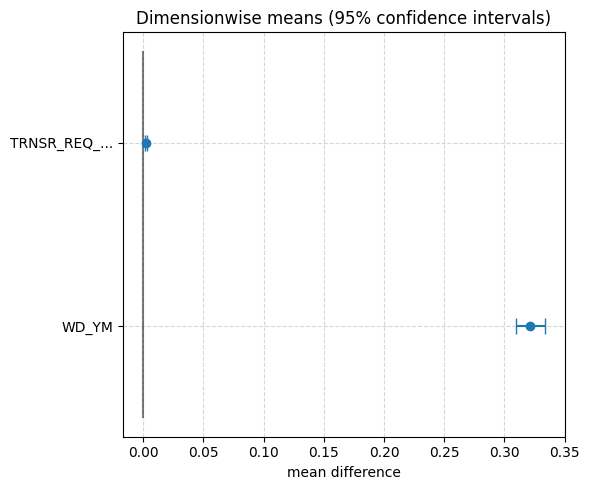

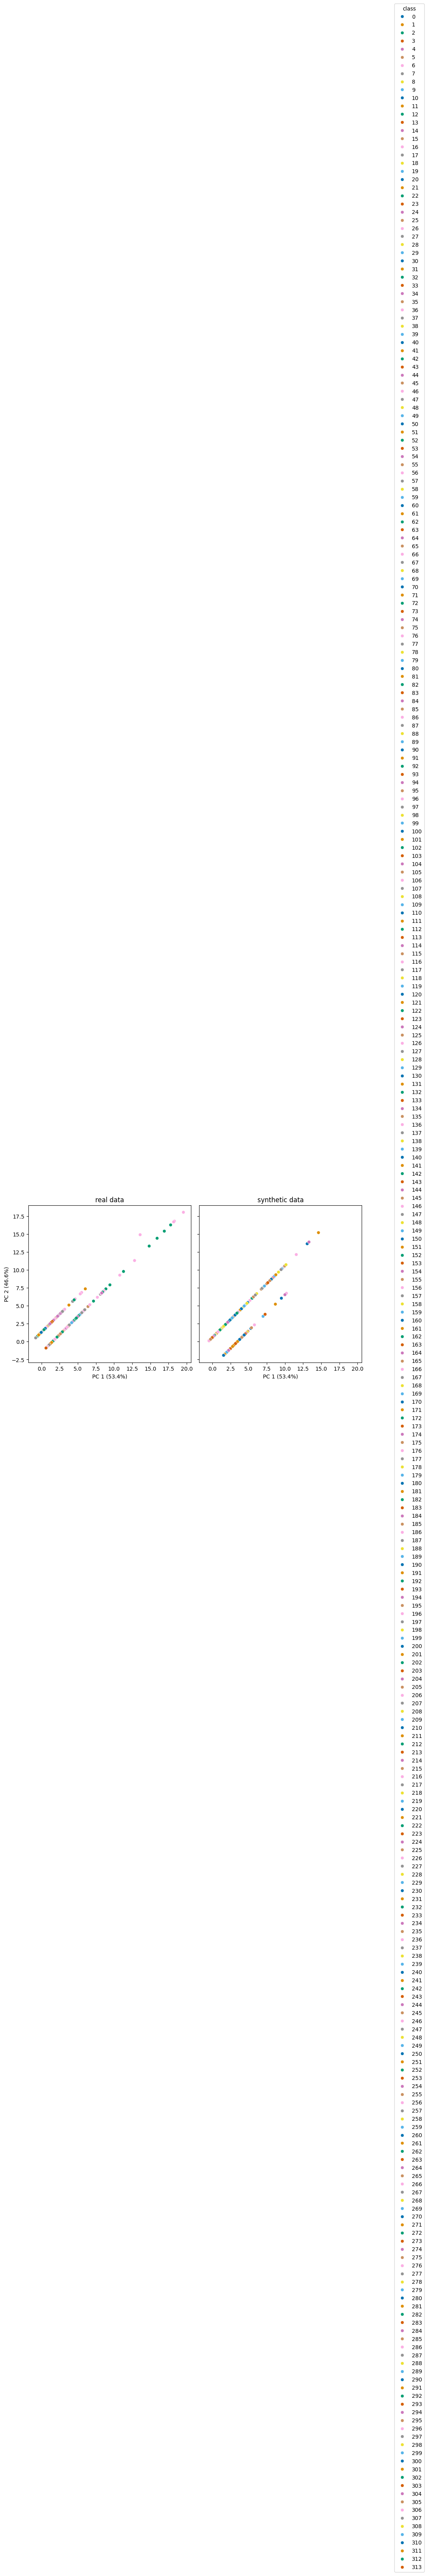

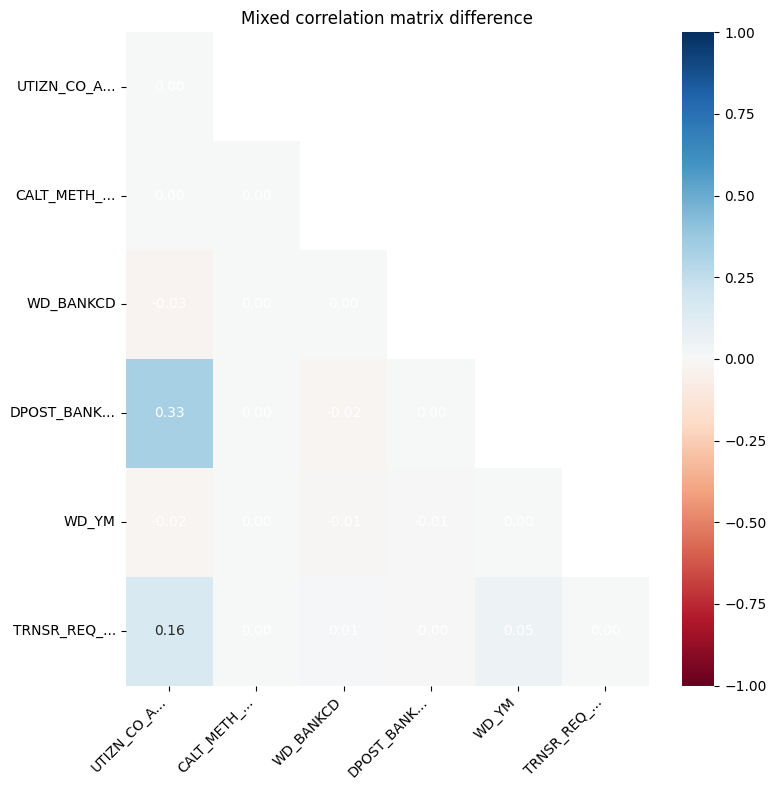

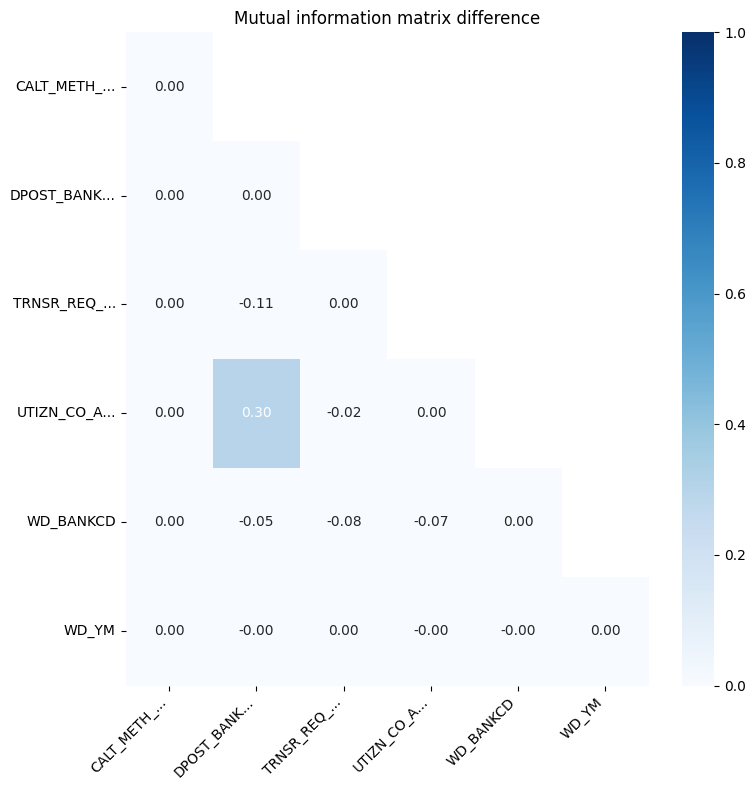

In [5]:
from syntheval import SynthEval
import warnings
warnings.filterwarnings("ignore", message="Creating legend with loc='best'")

# synthetic_data = pd.read_csv(f'./syn_datasets/DATOP_HF_TRANS_ctgan_10000.csv')

categorical_columns = ['UTIZN_CO_APRVNO', 'CALT_METH_NM', 'WD_BANKCD', 'DPOST_BANKCD']

S = SynthEval(real_dataframe=org_datasets, cat_cols=categorical_columns)
analysis_target_var = 'UTIZN_CO_APRVNO' # for PCA
results = S.evaluate(synthetic_dataframe=synthetic_data, presets_file='full_eval', analysis_target_var=analysis_target_var)

print('##### Results Dataframe')
print(results)

results.to_csv(f'./evaluation/pg_trans/{n_org_samples}_to_{n_syn_samples}/{model_name}/eval_metrics.csv', index=False)
